In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

def normalize(data, method='minmax', min_value=None, max_value=None):
    """
    多方法归一化函数
    
    参数:
    - data: 需要归一化的数组或数据框列
    - method: 归一化方法，可选['minmax', 'standard', 'log', 'log_minmax']
    - min_value: 最小值（可选）
    - max_value: 最大值（可选）
    
    返回:
    - 归一化后的数据
    - 用于反归一化的参数字典
    """
    params = {}
    
    if method == 'minmax':
        if min_value is None:
            min_value = data.min()
        if max_value is None:
            max_value = data.max()
        normalized_data = (data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    elif method == 'standard':
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
        normalized_data = pd.Series(normalized_data, index=data.index)  # 转换回Series
        params = {'mean': scaler.mean_, 'std': scaler.scale_}
        
    elif method == 'log':
        normalized_data = np.log1p(data)
        params = {'method': 'log'}
        
    elif method == 'log_minmax':
        # 先对数变换
        log_data = np.log1p(data)
        # 再归一化
        if min_value is None:
            min_value = log_data.min()
        if max_value is None:
            max_value = log_data.max()
        normalized_data = (log_data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return normalized_data, params

def denormalize(normalized_data, params, method='minmax'):
    if method == 'minmax':
        original_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        
    elif method == 'standard':
        original_data = normalized_data * params['std'] + params['mean']
        
    elif method == 'log':
        original_data = np.expm1(normalized_data)
        
    elif method == 'log_minmax':
        # 先反归一化
        log_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        # 再指数变换
        original_data = np.expm1(log_data)
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return original_data

# 读取数据
df = pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv', header=0)
df['Power (MW)'], params =normalize(df['Power (MW)'])
target=df.iloc[-24:,:]
df=df.iloc[:-24,:]
# 确保时间列正确设置
if '时间' in df.columns:
    df['时间'] = pd.to_datetime(df['时间'])
    df.set_index('时间', inplace=True)
else:
    # 假设数据按15分钟间隔排列，生成时间戳索引
    start_time = pd.Timestamp('2022-01-01')
    df.index = pd.date_range(start=start_time, periods=len(df), freq='15T')

# 提取功率数据
data = df['Power (MW)'].values.reshape(-1, 1)

# 数据归一化（LSTM对输入范围敏感）
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 创建时间窗口数据集
def create_dataset(data, time_steps=24):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 24 * 4  # 使用前24小时数据预测（15分钟×96步）
X, y = create_dataset(data_scaled, time_steps=time_steps)

# 划分训练集和测试集（80/20）
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

C:\Users\12919\AppData\Local\Temp\ipykernel_2112\3149938581.py:95: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.index = pd.date_range(start=start_time, periods=len(df), freq='15T')


In [10]:
# 定义LSTM模型
model = Sequential()
model.add(LSTM(units=64, 
               return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 模型结构可视化
model.summary()

c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 96, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - loss: 0.0132 - val_loss: 0.0058
Epoch 2/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 3/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 4/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 5/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 6/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 7/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 8/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 9/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 10/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 11/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 12/100
679/67

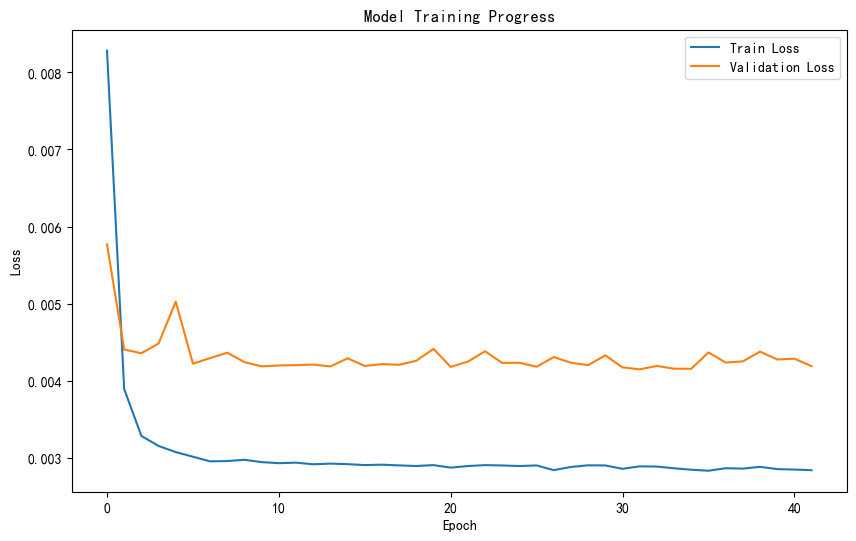

In [11]:
# 设置早停法防止过拟合
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 训练模型
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 绘制训练过程曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
print(history.history['loss'])
print(history.history['val_loss'])

[0.008280412293970585, 0.003892055945470929, 0.00328426924534142, 0.0031542067881673574, 0.0030745600815862417, 0.0030147649813443422, 0.00295450771227479, 0.002958460943773389, 0.002974825445562601, 0.002945010317489505, 0.0029306579381227493, 0.002937768353149295, 0.0029165626037865877, 0.0029251871164888144, 0.00291828578338027, 0.0029060051310807467, 0.002911484567448497, 0.002901954809203744, 0.002894166624173522, 0.002905897796154022, 0.0028731764759868383, 0.002893524244427681, 0.002905680099502206, 0.002900987397879362, 0.0028939167968928814, 0.002901562489569187, 0.0028403885662555695, 0.002881933469325304, 0.00290312385186553, 0.0029015792533755302, 0.0028577703051269054, 0.002889942144975066, 0.0028869695961475372, 0.0028641954995691776, 0.0028460125904530287, 0.002833038102835417, 0.002865528455004096, 0.0028606033883988857, 0.002883197506889701, 0.002854017075151205, 0.0028481401968747377, 0.002839777385815978]
[0.005767352879047394, 0.004405038431286812, 0.004356510937213

425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
RMSE: 0.05 MW
MAE: 0.03 MW


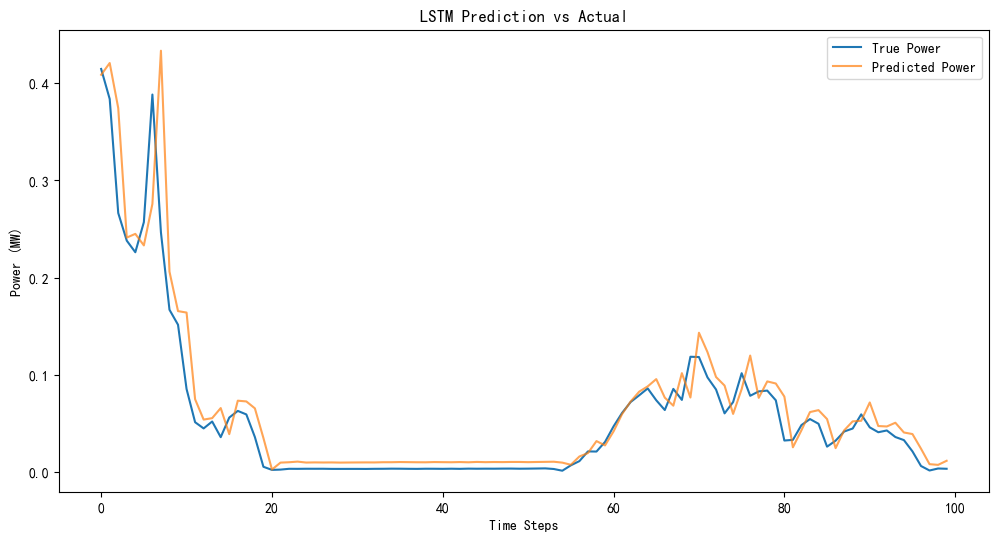

In [13]:
# 在测试集上进行预测
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y_test)

# 计算评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f'RMSE: {rmse:.2f} MW')
print(f'MAE: {mae:.2f} MW')

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_true[-100:], label='True Power')
plt.plot(y_pred[-100:], label='Predicted Power', alpha=0.7)
plt.title('LSTM Prediction vs Actual')
plt.ylabel('Power (MW)')
plt.xlabel('Time Steps')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\12919\AppData\Local\Temp\ipykernel_2112\3091270050.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_index = pd.date_range(


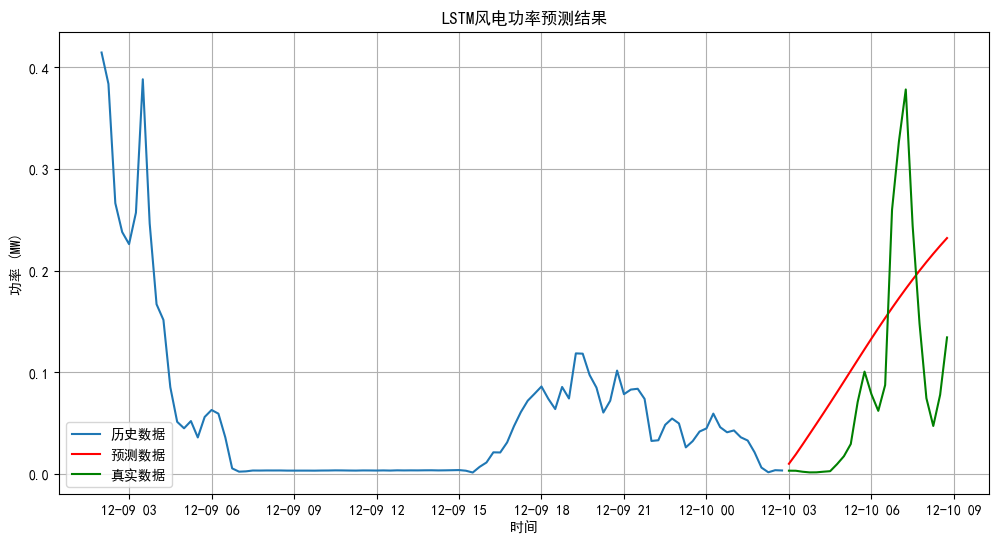

In [14]:
def forecast_future(model, last_sequence, steps=24):
    forecast = []
    current_sequence = last_sequence.copy()
    for _ in range(steps):
        next_step = model.predict(current_sequence.reshape(1, time_steps, 1))
        forecast.append(next_step[0,0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_step
    return np.array(forecast)

# 获取最后的time_steps长度数据
last_sequence = data_scaled[-time_steps:]

# 预测未来24步（6小时）
future_forecast_scaled = forecast_future(model, last_sequence, steps=24)
future_forecast = scaler.inverse_transform(future_forecast_scaled.reshape(-1, 1))

# 生成时间索引
forecast_index = pd.date_range(
    start=df.index[-1] + pd.Timedelta(minutes=15),
    periods=24,
    freq='15T'
)

# 保存预测结果
forecast_df = pd.DataFrame({'预测功率': future_forecast.flatten()}, index=forecast_index)
forecast_df.to_excel('LSTM_风电功率预测结果.xlsx')

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Power (MW)'][-100:], label='历史数据')
plt.plot(forecast_df.index, forecast_df['预测功率'], label='预测数据', color='red')
plt.plot(forecast_df.index,target["Power (MW)"], label='真实数据', color='green')
plt.title('LSTM风电功率预测结果')
plt.ylabel('功率 (MW)')
plt.xlabel('时间')
plt.legend()
plt.grid()
plt.show()
   

In [16]:
denormalize(forecast_df['预测功率'],params=params,method='minmax').tolist()

[0.9248948693275452,
 1.7750107049942017,
 2.6847341060638428,
 3.61476731300354,
 4.54779577255249,
 5.489797592163086,
 6.444090366363525,
 7.410119533538818,
 8.384541511535645,
 9.362678527832031,
 10.33946704864502,
 11.310009956359863,
 12.269848823547363,
 13.215100288391113,
 14.142478942871094,
 15.049285888671875,
 15.933349609375,
 16.7929744720459,
 17.62688446044922,
 18.434175491333008,
 19.214265823364258,
 19.96685218811035,
 20.69186782836914,
 21.389448165893555]

模型参数总结：
优化器: adam
学习率: 0.0010000000474974513
损失函数: mse
LSTM 层数: 2
Dropout 率: 0.2
隐藏单元数: 64
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
RMSE: 4.64 MW
MAE: 2.57 MW
R²: 0.9658

预测结果统计信息：
真实值均值: 22.49 MW
预测值均值: 22.12 MW
残差均值: 0.38 MW
残差标准差: 4.63 MW
最大残差: 67.32 MW
最小残差: 0.00 MW


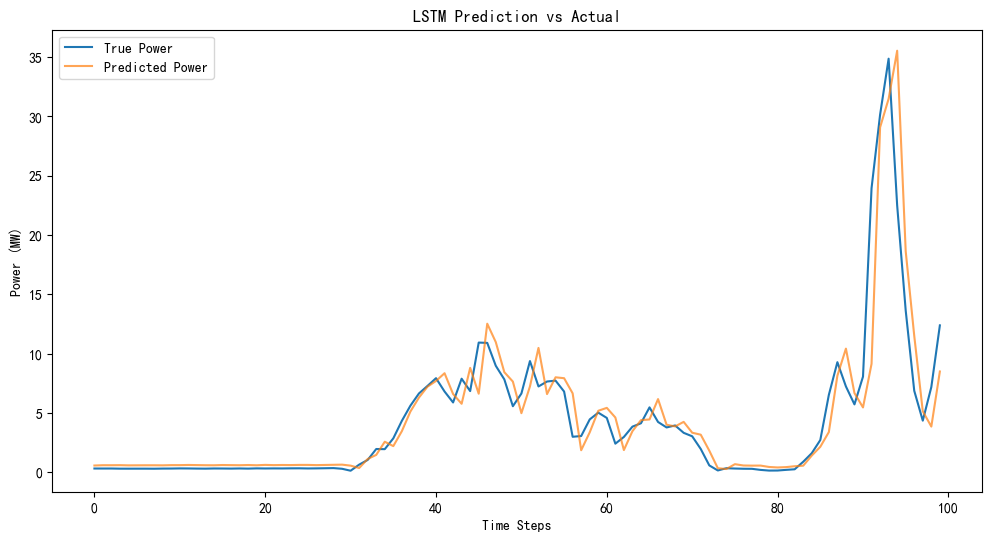

In [9]:
# 输出模型参数
def print_model_parameters(model):
    print("模型参数总结：")
    print(f"优化器: {model.optimizer.get_config()['name']}")
    print(f"学习率: {model.optimizer.get_config()['learning_rate']}")
    print(f"损失函数: {model.loss}")
    print(f"LSTM 层数: {len([layer for layer in model.layers if isinstance(layer, LSTM)])}")
    print(f"Dropout 率: {model.layers[1].rate}")  # 假设第一个 Dropout 层是第二层
    print(f"隐藏单元数: {model.layers[0].units}")  # 假设第一个 LSTM 层是输入层

# 在模型编译后调用
print_model_parameters(model)

# 在测试集上进行预测
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y_test)

# 计算评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f'RMSE: {rmse:.2f} MW')
print(f'MAE: {mae:.2f} MW')
print(f'R²: {r2:.4f}')

# 输出预测结果的统计信息
def print_prediction_stats(y_true, y_pred):
    residuals = y_true - y_pred
    print("\n预测结果统计信息：")
    print(f"真实值均值: {np.mean(y_true):.2f} MW")
    print(f"预测值均值: {np.mean(y_pred):.2f} MW")
    print(f"残差均值: {np.mean(residuals):.2f} MW")
    print(f"残差标准差: {np.std(residuals):.2f} MW")
    print(f"最大残差: {np.max(np.abs(residuals)):.2f} MW")
    print(f"最小残差: {np.min(np.abs(residuals)):.2f} MW")

print_prediction_stats(y_true, y_pred)

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_true[-100:], label='True Power')
plt.plot(y_pred[-100:], label='Predicted Power', alpha=0.7)
plt.title('LSTM Prediction vs Actual')
plt.ylabel('Power (MW)')
plt.xlabel('Time Steps')
plt.legend()
plt.show()